
Test Accuracy (Random Forest): 87.77%
Classification Report (Random Forest):
                 precision    recall  f1-score   support

      Positive       0.86      0.92      0.89      1262
      Negative       0.85      0.93      0.88      1257
  Not_relevant       0.82      0.69      0.75      1238
Mixed Feelings       0.99      1.00      0.99      1218
       Neutral       0.87      0.86      0.87      1312

      accuracy                           0.88      6287
     macro avg       0.88      0.88      0.88      6287
  weighted avg       0.88      0.88      0.88      6287



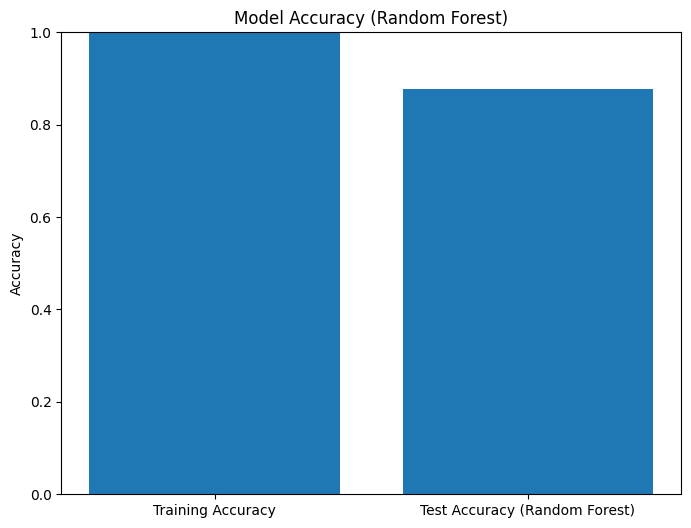

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load data from CSV
file_path = 'final_manglish_transliterated.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['transliterated_text'] = data['transliterated_text'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and word embedding using Word2Vec
sentences = [text.split() for text in data['transliterated_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

# Function to convert text data to Word2Vec embeddings
def text_to_vector(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

X = np.vstack([text_to_vector(text) for text in data['transliterated_text']])
y = data['Sentiment_Class']

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']],
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Convert upsampled text data to Word2Vec embeddings
upsampled_sentences = [text.split() for text in data_upsampled['transliterated_text']]
X_upsampled = np.vstack([text_to_vector(text) for text in data_upsampled['transliterated_text']])
y_upsampled = data_upsampled['Sentiment_Class']

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=10)

# Build and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model on test data
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nTest Accuracy (Random Forest): {accuracy_rf * 100:.2f}%")

# Generate predictions for Random Forest
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_pred_labels_rf = [reverse_sentiment_dict[label] for label in y_pred_rf]

# Print complete classification report for Random Forest
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf, target_names=sentiment_dict.keys()))

# Plotting the accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Training Accuracy', 'Test Accuracy (Random Forest)'], [accuracy_score(y_train, rf_model.predict(X_train)), accuracy_rf])
plt.ylabel('Accuracy')
plt.title('Model Accuracy (Random Forest)')
plt.ylim(0, 1)
plt.show()


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Model Test Accuracy (Random Forest): 90.68%
Best Model Classification Report (Random Forest):
                 precision    recall  f1-score   support

      Positive       0.98      1.00      0.99      1218
      Negative       0.91      0.92      0.92      1257
  Not_relevant       0.90      0.86      0.88      1312
Mixed Feelings       0.84      0.84      0.84      1238
       Neutral       0.91      0.91      0.91      1262

      accuracy                           0.91      6287
     macro avg       0.91      0.91      0.91      6287
  weighted avg       0.91      0.91      0.91      6287



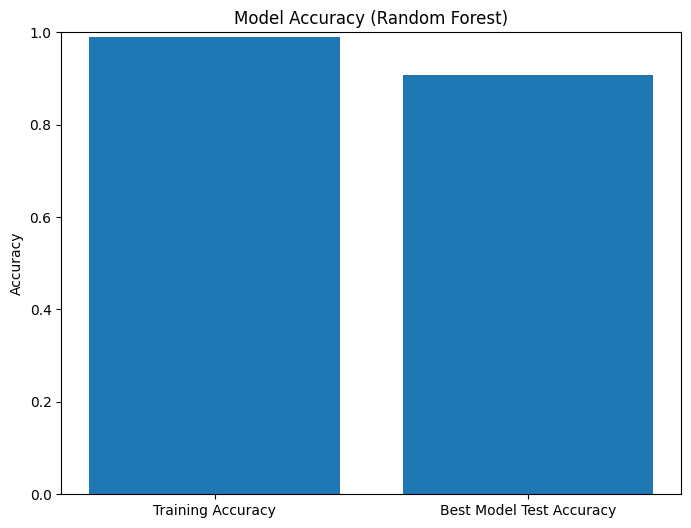

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# Load data from CSV
file_path = 'final_manglish_transliterated.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['transliterated_text'] = data['transliterated_text'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and sequence padding using TF-IDF
max_words = 1000
max_seq_length = 100
tfidf_vectorizer = TfidfVectorizer(max_features=max_words)
X = tfidf_vectorizer.fit_transform(data['transliterated_text'])
y = data['Sentiment_Class']

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and sequence padding for balanced data using TF-IDF
X_upsampled = tfidf_vectorizer.fit_transform(data_upsampled['transliterated_text'])
y_upsampled = data_upsampled['Sentiment_Class']

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=10)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],  # You can adjust these values as needed
    'max_depth': [None, 10, 20]  # You can adjust these values as needed
}

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with progress bar
grid_search = GridSearchCV(rf_model, param_grid, cv=5, verbose=2, n_jobs=-1)

# Perform grid search to find optimal hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred_rf = best_rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nBest Model Test Accuracy (Random Forest): {accuracy_rf * 100:.2f}%")

# Generate predictions for best model
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_pred_labels_rf = [reverse_sentiment_dict[label] for label in y_pred_rf]

# Convert y_test to string labels
y_test_labels = [reverse_sentiment_dict[label] for label in y_test]

# Print complete classification report for best model
print("Best Model Classification Report (Random Forest):\n", classification_report(y_test_labels, y_pred_labels_rf, target_names=sentiment_dict.keys()))

# Plotting the accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Training Accuracy', 'Best Model Test Accuracy'], [accuracy_score(y_train, best_rf_model.predict(X_train)), accuracy_rf])
plt.ylabel('Accuracy')
plt.title('Model Accuracy (Random Forest)')
plt.ylim(0, 1)
plt.show()
